## FastText into AiHub Data (Phase 1)

[2024.04.04] 
- [링크](https://museonghwang.github.io/nlp(natural%20language%20processing)/2023/02/10/nlp-kor-fasttext/) 참고하여 자모 분리 및 FastText 학습시도

[2024.04.05] 
- Colab 환경에서 Mecab을 이용하여 약 19만개를 모두 토큰화 및 자모 분리 시도 -> ⚠ 끝날 기미가 안 보임
- 클래스 비율에 맞게 데이터 크기를 줄이고, ```바른```으로 토큰화 및 자모 분리 시도

In [1]:
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm
import hgtk
from bareunpy import Tagger

### 1. 데이터 확인 및 클래스 분포 확인
- Part 1은 아직 작업 시작 안 함
- Part 2는 비낚시성은 모두 가져오고, 낚시성은 직접생성 부분만 가져옴(자동 생성은 안 가져옴)

In [3]:
p2_Bait = pd.read_pickle('C:/Python_Programs/YoutubeFakeNewsDetection/AiHub_Data/part2_bait_direct.pkl')
p2_NonBait = pd.read_pickle('C:/Python_Programs/YoutubeFakeNewsDetection/AiHub_Data/Part2_NonBait_Auto.pkl')

In [4]:
# 본문의 도메인 일관성 부족 기사(Part 2)
p2_data = pd.concat([p2_Bait, p2_NonBait], axis=0)
print(p2_data.shape)

(185456, 8)


In [5]:
p2_data.head()

,ID,Category,Subcategory,Title,Content,Part Number,Process Pattern,Label
0,GB_M12_639555,세계,일본,스가 관방장관 “도쿄올림픽 예정대로 진행한다”,일본 정부가 오는 7월로 예정된 도쿄올림픽·패럴림픽을 그대로 개최하기 위해 준비하고...,P2,24,1
1,GB_M12_639204,세계,미국,미국에서 전자담배 관련 폐 질환 환자 증가,미국에서 전자담배로 인한 호흡기 질환 환자는 500명을 넘어섰고 이중 8번째 사망자...,P2,24,1
2,GB_M12_638733,세계,국제일반,女 국가정상에 꽃다발 선물은 모욕? 특권?… 독일-러시아 ‘꽃다발’ 논란,독일과 러시아 간 때 아닌 ‘꽃다발’ 논란이 불거졌다.\n블라디미르 푸틴 러시아 대...,P2,24,1
3,GB_M11_634965,세계,미국ㆍ캐나다,"트럼프 \""코로나로 10만명 죽으면 매우 잘한 것\""",미국 내 신종 코로나바이러스 감염증(코로나19) 확진자와 사망자가 가파르게 늘고 있...,P2,23,1
4,GB_M11_643377,세계,유럽,스페인 코로나19 확진자 8만명 육박…中 추월 임박,유럽에서 이탈리아 다음으로 신종 코로나바이러스 감염증(코로나19) 피해가 심각한 스...,P2,21,1


In [6]:
def plot_class_distribution(data, part):
    count_0 = np.sum(data['Label'] == 0)
    count_1 = np.sum(data['Label'] == 1)

    # 파이차트 그리기
    labels = ['Non Bait', 'Bait']
    sizes = [count_0, count_1]
    colors = ['lightcoral', 'lightskyblue']
    explode = (0, 0.1)  # 클래스를 강조하기 위해서 간격 설정

    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=120)
    plt.axis('equal')  # 원이 눌리지 않도록 설정
    plt.title(f'Class Distribution of {part}')
    plt.show()

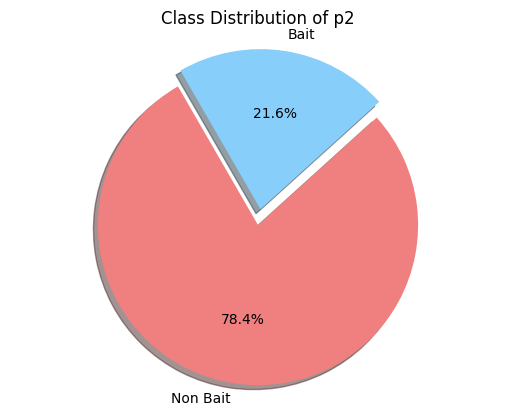

In [7]:
# Part 2 데이터의 레이블 분포 확인
plot_class_distribution(p2_data, 'p2')

### 2. 자모 분리에 필요한 패키지 다운로드

In [9]:
# 필요한 패키지 다운로드 - 한글 자모 단위 처리
!pip install hgtk

#### 2-1. 한국어 자모 분리 시도

In [10]:
# 한글인지 체크
hgtk.checker.is_hangul('ㄱ')

True

In [11]:
# 한글인지 체크
hgtk.checker.is_hangul('28')

False

In [12]:
# 음절을 초성, 중성, 종성으로 분해
hgtk.letter.decompose('남')

('ㄴ', 'ㅏ', 'ㅁ')

In [13]:
# 초성, 중성을 결합
hgtk.letter.compose('ㄴ', 'ㅏ')

'나'

In [14]:
# 초성, 중성, 종성을 결합
hgtk.letter.compose('ㄴ', 'ㅏ', 'ㅁ')

'남'

아래의 함수는 단어를 초성, 중성, 종성으로 분리해주는 함수입니다.
- 단, 종성이 없는 경우에는 해당 위치에 종성이 없었다는 것을 표시해주기 위해서 종성의 위치에 특수문자 ‘‐’ 를 넣어줌

In [6]:
def word_to_jamo(token):
    def to_special_token(jamo):
        if not jamo:
            return '-'
        else:
            return jamo

    decomposed_token = ''
    for char in token:
        try:
            # char(음절)을 초성, 중성, 종성으로 분리
            cho, jung, jong = hgtk.letter.decompose(char)

            # 자모가 빈 문자일 경우 특수문자 -로 대체
            cho = to_special_token(cho)
            jung = to_special_token(jung)
            jong = to_special_token(jong)
            decomposed_token = decomposed_token + cho + jung + jong

        # 만약 char(음절)이 한글이 아닐 경우 자모를 나누지 않고 추가
        except Exception as exception:
            if type(exception).__name__ == 'NotHangulException':
                decomposed_token += char

    # 단어 토큰의 자모 단위 분리 결과를 추가
    return decomposed_token

In [16]:
# 함수가 잘 작동하나 확인
word_to_jamo('남동생')

'ㄴㅏㅁㄷㅗㅇㅅㅐㅇ'

### 3. 바른 형태소 분석기 정의
- 예시에서는 Mecab을 사용했는데, 로컬 환경에서는 사용이 어렵습니다.
- 성능이 뛰어난 ```바른```을 사용하겠습니다.

In [2]:
# 바른 형태소 분석기 정의
API_KEY = "--"
baruen_tagger = Tagger(API_KEY, 'localhost')

In [3]:
res = baruen_tagger.tags(['선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다.'])
print(res.morphs())

['선물', '용', '으로', '빨리', '받', '아서', '전달하', '았', '어야', '하', '는', '상품', '이', '었', '는데', '머그', '컵', '만', '오', '아서', '당황하', '았', '습니다', '.']


아래의 함수는 문장을 형태소로 분리하고, 이를 자모로 분리해주는 함수입니다.

In [4]:
def tokenize_by_jamo(s):
    return [word_to_jamo(token) for token in baruen_tagger.morphs(s)]

In [7]:
# 시도
print(tokenize_by_jamo('선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다.'))

['ㅅㅓㄴㅁㅜㄹ', 'ㅇㅛㅇ', 'ㅇㅡ-ㄹㅗ-', 'ㅃㅏㄹㄹㅣ-', 'ㅂㅏㄷ', 'ㅇㅏ-ㅅㅓ-', 'ㅈㅓㄴㄷㅏㄹㅎㅏ-', 'ㅇㅏㅆ', 'ㅇㅓ-ㅇㅑ-', 'ㅎㅏ-', 'ㄴㅡㄴ', 'ㅅㅏㅇㅍㅜㅁ', 'ㅇㅣ-', 'ㅇㅓㅆ', 'ㄴㅡㄴㄷㅔ-', 'ㅁㅓ-ㄱㅡ-', 'ㅋㅓㅂ', 'ㅁㅏㄴ', 'ㅇㅗ-', 'ㅇㅏ-ㅅㅓ-', 'ㄷㅏㅇㅎㅘㅇㅎㅏ-', 'ㅇㅏㅆ', 'ㅅㅡㅂㄴㅣ-ㄷㅏ-', '.']


### 4. 데이터 비복원 추출 및 토큰화&자모 분리 진행

이제 클래스 비율에 맞게 데이터를 일부만 추출해서 토큰화 -> 자모 분리를 진행하겠습니다.

In [35]:
# 원본 데이터 클래스 비율 확인 및 정의
counter = Counter(p2_data['Label'])
bait = counter[1]
non_bait = counter[0]

bait_percentage = bait/(bait+non_bait)
nonbait_percentage = non_bait/(bait+non_bait)

print(f'bair : {bait_percentage}, non-bait : {nonbait_percentage}')

bair : 0.21627232335432664, non-bait : 0.7837276766456733


In [36]:
# 원하는 샘플 크기
choose_size = 50000

# Label이 1과 0인 데이터 분리
bait_data = p2_data[p2_data['Label'] == 1]
nonbait_data = p2_data[p2_data['Label'] == 0]

# 각 Label에 대해 원하는 수의 샘플 추출
bait_sample = bait_data.sample(n=int(choose_size * bait_percentage), replace=False)
nonbait_sample = nonbait_data.sample(n=int(choose_size * nonbait_percentage), replace=False)

# 두 샘플을 합쳐서 새로운 데이터셋 생성
random_p2_data = pd.concat([bait_sample, nonbait_sample])

In [39]:
# 비복원 추출 후 클래스 비율 확인
counter = Counter(random_p2_data['Label'])
bait = counter[1]
non_bait = counter[0]

bait_percentage = bait/(bait+non_bait)
nonbait_percentage = non_bait/(bait+non_bait)

print(f'bair : {bait_percentage}, non-bait : {nonbait_percentage}')

bair : 0.21626432528650574, non-bait : 0.7837356747134943


In [40]:
# 만일을 대비하여 비복원 추출 데이터 저장
random_p2_data.to_pickle('random_p2_data.pkl')

In [9]:
# 읽어오기
random_p2_data = pd.read_pickle('random_p2_data.pkl')

- 비복원 추출로 비율을 유지해서 5만개로 데이터를 줄였습니다. 약 19만개를 다 사용하면 학습시간이 너무 걸립니다ㅜㅜ

In [11]:
# 토큰화&자모 분리 시작
count = 0

# 토큰화 결과를 담을 리스트
tokenized_data = []

for sample in random_p2_data['Content'].to_list():
    start_time = time.time()
    tokenzied_sample = tokenize_by_jamo(sample) # 자소 단위 토큰화
    tokenized_data.append(tokenzied_sample)
    count += 1

    # 경과시간 출력
    if count % 100 == 0:
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f'{count} sample processed. Elapsed time : {round(elapsed_time // 60, 0)}m {round(elapsed_time % 60, 0)}s')

100 sample processed. Elapsed time : 0.0m 9.0s
200 sample processed. Elapsed time : 0.0m 8.0s
300 sample processed. Elapsed time : 0.0m 8.0s
400 sample processed. Elapsed time : 0.0m 7.0s
500 sample processed. Elapsed time : 0.0m 8.0s
600 sample processed. Elapsed time : 0.0m 9.0s
700 sample processed. Elapsed time : 0.0m 8.0s
800 sample processed. Elapsed time : 0.0m 9.0s
900 sample processed. Elapsed time : 0.0m 8.0s
1000 sample processed. Elapsed time : 0.0m 7.0s
1100 sample processed. Elapsed time : 0.0m 9.0s
1200 sample processed. Elapsed time : 0.0m 9.0s
1300 sample processed. Elapsed time : 0.0m 8.0s
1400 sample processed. Elapsed time : 0.0m 8.0s
1500 sample processed. Elapsed time : 0.0m 4.0s
1600 sample processed. Elapsed time : 0.0m 5.0s
1700 sample processed. Elapsed time : 0.0m 8.0s
1800 sample processed. Elapsed time : 0.0m 9.0s
1900 sample processed. Elapsed time : 0.0m 8.0s
2000 sample processed. Elapsed time : 0.0m 8.0s
2100 sample processed. Elapsed time : 0.0m 9.0s
2

In [12]:
# 첫번째 데이터에 대한 자모 분리 결과
tokenized_data[0][0:10]

['ㅇㅏㅍ',
 'ㅇㅡ-ㄹㅗ-',
 'ㅅㅏ-ㅇㅓㅂㅈㅏ-',
 'ㄱㅏ-',
 'ㅅㅡ-ㅁㅏ-ㅌㅡ-ㅍㅗㄴ',
 'ㅇㅣ-ㄴㅏ-',
 'USB',
 'ㄷㅡㅇ',
 'ㅇㅔ-',
 'ㅌㅏ-ㅇㅣㄴ']

In [13]:
random_p2_data['Content'].iloc[0, ]

"앞으로 사업자가 스마트폰이나 USB 등에 타인의 정보를 저장하기 위해서는 해당 개인정보를 암호화해야 한다.\n개인정보 유출을 막기 위해 전산실, 자료보관실 등에 대해서는 출입을 통제해야 한다.\n방송통신위원회는 8일 전체회의를 열고 이같은 내용의 '개인정보의 기술적·관리적 보호조치 기준' 일부 개정안을 접수했다고 밝혔다.\n개정안에 따르면 현재 컴퓨터로 한정된 개인정보를 저장할 때 암호화해야 하는 장치를 모바일 기기 및 보조저장매체로 추가했다.\n이에 따라 스마트폰이나 USB 등에 개인정보를 저장하기 위해서는 암호화해야 한다.\n보조저장매체 등을 통한 개인정보 유출을 막기 위해 전산실, 자료보관실 등에 대한 출입통제와 보조저장매체의 반출·입 통제 근거를 신설했다.\n개인정보취급자의 컴퓨터는 물론 모바일 기기도 접근통제 조치를 해야 한다.\n또 개인정보처리시스템에 대한 접속이 필요한 시간에 한해 유지되도록 '최대 접속시간 조치' 등을 취해야 한다.\n정보통신망 이용촉진 및 정보보호 등에 관한 법률(정보통신망법) 및 시행령 개정을 반영해 암호화 대상에 비밀번호, 바이오정보, 주민등록번호, 신용카드번호, 계좌번호 외 여권번호, 운전면허번호, 외국인등록번호를 추가했다.\n개인정보 유출 사고때 신속한 대응 조치를 취할 수 있도록 '개인정보 유출사고 등 발생시 대응절차 및 방법에 관한 사항'을 사업자의 내부관리계획에 포함하도록 했다.\n개인정보처리시스템 접속시 공인인증서 뿐만 아니라 다양한 인증수단을 사용할 수 있도록 '공인인증서 등'을 삭제했고 비밀번호 작성규칙은 '영문·숫자·특수문자'로 간소화했다.\n아울러 '최소한의 기준 원칙' 및 개인정보보호 안전성 확보 근거도 마련했다."

In [14]:
# 토큰화 결과 저장
import pickle

with open('random_p2_tokenized_data.pkl',"wb") as f:
    pickle.dump(tokenized_data, f)

In [16]:
# 잘 저장되었는지 확인
with open("random_p2_tokenized_data.pkl","rb") as f:
    tokenized_data = pickle.load(f)

tokenized_data[0][:10]

['ㅇㅏㅍ',
 'ㅇㅡ-ㄹㅗ-',
 'ㅅㅏ-ㅇㅓㅂㅈㅏ-',
 'ㄱㅏ-',
 'ㅅㅡ-ㅁㅏ-ㅌㅡ-ㅍㅗㄴ',
 'ㅇㅣ-ㄴㅏ-',
 'USB',
 'ㄷㅡㅇ',
 'ㅇㅔ-',
 'ㅌㅏ-ㅇㅣㄴ']

이제 자모로 분리한 결과를 단어로 합쳐주는 함수를 정의합니다.

In [48]:
def jamo_to_word(jamo_sequence):
    tokenized_jamo = []
    index = 0

    # 1. 초기 입력
    # jamo_sequence = 'ㄴㅏㅁㄷㅗㅇㅅㅐㅇ'

    while index < len(jamo_sequence):
        # 문자가 한글(정상적인 자모)이 아닐 경우
        if not hgtk.checker.is_hangul(jamo_sequence[index]):
            tokenized_jamo.append(jamo_sequence[index])
            index = index + 1

        # 문자가 정상적인 자모라면 초성, 중성, 종성을 하나의 토큰으로 간주.
        else:
            tokenized_jamo.append(jamo_sequence[index:index + 3])
            index = index + 3

    # 2. 자모 단위 토큰화 완료
    # tokenized_jamo : ['ㄴㅏㅁ', 'ㄷㅗㅇ', 'ㅅㅐㅇ']

    word = ''
    try:
        for jamo in tokenized_jamo:

            # 초성, 중성, 종성의 묶음으로 추정되는 경우
            if len(jamo) == 3:
                if jamo[2] == "-":
                    # 종성이 존재하지 않는 경우
                    word = word + hgtk.letter.compose(jamo[0], jamo[1])
                else:
                    # 종성이 존재하는 경우
                    word = word + hgtk.letter.compose(jamo[0], jamo[1], jamo[2])
            # 한글이 아닌 경우
            else:
                word = word + jamo

    # 복원 중(hgtk.letter.compose) 에러 발생 시 초기 입력 리턴.
    # 복원이 불가능한 경우 예시) 'ㄴ!ㅁㄷㅗㅇㅅㅐㅇ'
    except Exception as exception:
        if type(exception).__name__ == 'NotHangulException':
            return jamo_sequence

    return word

In [ ]:
# 지금은 적용할 필요가 없어서 넘어가겠습니다.
result = []
for w in tokenized_data[0]:
    result.append(jamo_to_word(w))